<a href="https://colab.research.google.com/github/enisbe/stock-trading-app/blob/main/run_deployed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np

import io
import sys
import datetime
from datetime import date, timedelta
from pandas.tseries.offsets import Day, MonthBegin, MonthEnd
from google.colab import drive
from google.colab import files

import random

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv1D,BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
import matplotlib as mpl

### Call saved Model

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!ls /content/gdrive/MyDrive/models

assets	keras_metadata.pb  saved_model.pb  variables


In [8]:
#recon_model = keras.models.load_model('/content/gdrive/MyDrive/models02')
recon_model = keras.models.load_model('/content/gdrive/MyDrive/models')

### load Stock data

In [9]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
# Libraries for stock data
import yfinance as yf
import requests

**Read in Data**<br>

In [11]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
# grab all tickers and put them into a list
Symbols = first_table['Symbol'].tolist()
# pass all symbols to basket
basket = Symbols

#### Functions

In [19]:
def stock_data_pull(start,end):
  """
  Download Stock data
  """
  stock_final = pd.DataFrame()
  # iterate over each symbol
  for i in basket:  
      
      # print the symbol which is being downloaded
      print( str(basket.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
      
      try:
          # download the stock price 
          stock = []
          stock = yf.download(i,start=start, end=end, progress=False)
          
          # append the individual stock prices 
          if len(stock) == 0:
              None
          else:
              stock['Name']=i
              stock_final = stock_final.append(stock,sort=False)
      except Exception:
          None
  return stock_final



def fill_blanks(df,srl_num,range,value_variable,date_variable):
  """
  fills missing observations
  some stocks may not have the same number of observations
  """
  stage_df = df.copy()
  for comb in stage_df[srl_num].unique(): 
    temp = stage_df[stage_df[srl_num] == comb].copy()
    stage_df = stage_df[stage_df[srl_num] != comb] # remove existing series detail
    temp2 = range.merge(temp,how='left',on=date_variable)
    # since we are filling missing data, other fields will be missing to
    # value info will be filled by zero, for other fields, we simply forward fill
    # Then back fill for full missing value coverage    
    #temp2[value_variable].fillna(0,inplace=True)
    temp2.fillna(method='ffill',inplace=True)
    temp2.fillna(method='bfill',inplace=True)
    # replace with new, full data subset
    stage_df = stage_df.append(temp2,ignore_index=True)
  return stage_df

In [20]:
start = datetime.datetime(2019,1,1)
end = date.today()

# New Section

In [21]:
stock_total = stock_data_pull(start,end)
stock_total.reset_index(inplace=True)
stock_total_slim = stock_total[['Date','Close','Name']]

# homogenous the samples in each stock
date_range = stock_total_slim.Date.drop_duplicates()
date_range = pd.DataFrame(date_range)

stock_ready = fill_blanks(stock_total_slim,'Name',date_range,'Close','Date')

0 : MMM,1 : AOS,2 : ABT,3 : ABBV,4 : ABMD,5 : ACN,6 : ATVI,7 : ADM,8 : ADBE,9 : ADP,10 : AAP,11 : AES,12 : AFL,13 : A,14 : AIG,15 : APD,16 : AKAM,17 : ALK,18 : ALB,19 : ARE,20 : ALGN,21 : ALLE,22 : LNT,23 : ALL,24 : GOOGL,25 : GOOG,26 : MO,27 : AMZN,28 : AMCR,29 : AMD,30 : AEE,31 : AAL,32 : AEP,33 : AXP,34 : AMT,35 : AWK,36 : AMP,37 : ABC,38 : AME,39 : AMGN,40 : APH,41 : ADI,42 : ANSS,43 : ANTM,44 : AON,45 : APA,46 : AAPL,47 : AMAT,48 : APTV,49 : ANET,50 : AIZ,51 : T,52 : ATO,53 : ADSK,54 : AZO,55 : AVB,56 : AVY,57 : BKR,58 : BLL,59 : BAC,60 : BBWI,61 : BAX,62 : BDX,63 : WRB,64 : BRK.B,
1 Failed download:
- BRK.B: No data found, symbol may be delisted
65 : BBY,66 : BIO,67 : TECH,68 : BIIB,69 : BLK,70 : BK,71 : BA,72 : BKNG,73 : BWA,74 : BXP,75 : BSX,76 : BMY,77 : AVGO,78 : BR,79 : BRO,80 : BF.B,
1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
81 : CHRW,82 : CDNS,83 : CZR,84 : CPT,85 : CPB,86 : COF,87 : CAH,88 : KMX,89 : CCL,90 : CARR,91 : CTLT,92 : 

In [22]:
# checks to ensure if all tckrs have same size
sizes = stock_ready.groupby('Name').size().unique()
size_count = sizes.shape[0]

if size_count == 1:
  print (f'all good, all data contain {sizes[0]} observations')
else:
  print(f'error, your stock contain tckrs with varying number of observations:{sizes}')


all good, all data contain 844 observations


In [23]:
stock_ready.sort_values(by=['Name','Date'],inplace=True)
stock_ready.head()

,Date,Close,Name
11815,2018-12-31,122.150002,A
10972,2019-01-02,65.690002,A
10973,2019-01-03,63.270000,A
10974,2019-01-04,65.459999,A
10975,2019-01-07,66.849998,A


### Create backtest and predict datasets

In [24]:
# input window and forecast horizon
window = 70
horizon = 10
theta = window+horizon

In [25]:
#stock_train = pd.DataFrame()
stock_test = pd.DataFrame()
stock_pred = pd.DataFrame()
for i, tckr in enumerate(stock_ready.Name.unique()):
  temp = stock_ready[stock_ready.Name == tckr].copy()
  if i == 0:
#    stock_train = temp.iloc[:-theta,:]
    stock_test = temp.iloc[-theta:,:]
    stock_pred = temp.iloc[-window:,:]
  else:
#    stock_train = pd.concat([stock_train, temp.iloc[:-theta,:] ])
    stock_test = pd.concat([stock_test, temp.iloc[-theta:,:] ])
    stock_pred = pd.concat([stock_pred, temp.iloc[-window:,:] ])

### Data Pipeline

- for each ticker in the test or prep dataset, get last 70 observations, then generate predictions
- build back out into a forecast dataset along with dates
- need to build future dates

#### Backtest

In [26]:
date_temp = stock_test.Date
date_temp = date_temp[-horizon:]
date_list = date_temp.tolist()

In [41]:
# prediction code - makes predictions per ticker
# adds actuals 
pred_list = []
for i, tckr in enumerate(stock_test.Name.unique()):
  #print(f'predicting for {tckr}')
  temp = stock_test[stock_test.Name == tckr].iloc[:window,:].copy()
  x_test_temp = temp.Close.values
  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)
  #x_test_temp, y_test_temp = single_data_build(temp)

  # true values
  temp_true = stock_test[stock_test.Name == tckr].iloc[window:,:].copy()
  y_true = temp_true.Close.values

  pred = recon_model.predict(test)

  pred = pred[:,:horizon][0]
  #stock = tckr
  for i in range(horizon):
    pred_list.append({'stock':tckr,'Date':date_list[i],'Forecasted_Close':pred[i],'Actual_Close':y_true[i]})

In [42]:
pred_bt_df = pd.DataFrame(pred_list)

In [43]:
pred_bt_df.head()

,stock,Date,Forecasted_Close,Actual_Close
0,A,2022-04-22,125.388451,121.320000
1,A,2022-04-25,125.103859,121.449997
2,A,2022-04-26,124.664154,117.940002
3,A,2022-04-27,124.767235,117.680000
4,A,2022-04-28,125.181641,121.059998


In [44]:
basket[:8]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM']

In [31]:
def perform(tckr, df, metric='mae'):
  temp = df[df.stock == tckr].copy()
  if metric == 'mae':
    score = mean_squared_error(temp.Actual_Close, temp.Forecasted_Close)
  else:
    score = mean_absolute_percentage_error(temp.Actual_Close, temp.Forecasted_Close)
  return (f'your {metric} score is: {score}')


In [45]:
perform('AMZN',pred_bt_df,'mape')

'your mape score is: 0.13979408255076547'

In [46]:
def plot_bt_stock(tckr, df):
  fig, ax = plt.subplots(figsize=(14,6))
  temp = df[df.stock == tckr].copy()
  historical = stock_test[stock_test.Name == tckr].copy()
#  ax.plot(temp['Date'], temp['Actual_Close'],'-g',label="Actual Stock Price")   #Actuals This should come from original DS (all actuals)
  ax.plot(historical['Date'], historical['Close'],'-g',label="Actual Stock Price")   #Actuals This should come from original DS (all actuals)
  ax.plot(temp['Date'], temp['Forecasted_Close'], '-r',alpha=0.75,label="Forecast")  ## Pred
  plt.title('Back Test')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')

  plt.legend()
  plt.show()

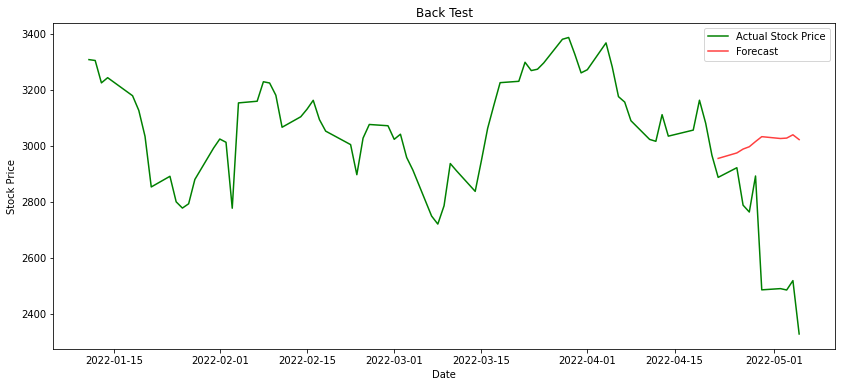

In [37]:
plot_bt_stock('AMZN',pred_bt_df)

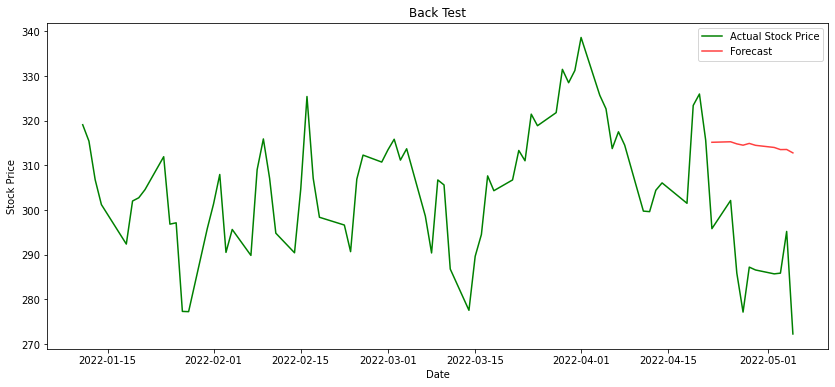

In [48]:
plot_bt_stock('ABMD',pred_bt_df)

#### Predict

In [76]:
# create future dates
from datetime import datetime

In [57]:
!pip install pandas_market_calendars

     |████████████████████████████████| 89 kB 3.4 MB/s 
     |████████████████████████████████| 150 kB 31.7 MB/s 
  Created wheel for exchange-calendars: filename=exchange_calendars-3.6.1-py3-none-any.whl size=180505 sha256=7a72a9c0bb2940e807863a79275e9fbd07bb700964a9b77afd9946295a092dc8
  Stored in directory: /root/.cache/pip/wheels/db/70/a2/5e1d8d0873feb8cb9808f3b55e8f270698b742db54a4b8ad2e
Successfully built exchange-calendars


In [58]:
import pandas_market_calendars as mcal

# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
print(mcal.get_calendar_names())

['ASX', 'BMF', 'CFE', 'CBOE_Futures', 'CBOE_Equity_Options', 'CBOE_Index_Options', 'CME_Equity', 'CBOT_Equity', 'CME_Agriculture', 'CBOT_Agriculture', 'COMEX_Agriculture', 'NYMEX_Agriculture', 'CME_Rate', 'CBOT_Rate', 'CME_InterestRate', 'CBOT_InterestRate', 'CME_Bond', 'CBOT_Bond', 'EUREX', 'HKEX', 'ICE', 'ICEUS', 'NYFE', 'NYSE', 'stock', 'NASDAQ', 'BATS', 'DJIA', 'DOW', 'IEX', 'Investors_Exchange', 'JPX', 'LSE', 'OSE', 'SIFMAUS', 'SIFMA_US', 'Capital_Markets_US', 'Financial_Markets_US', 'Bond_Markets_US', 'SIFMAUK', 'SIFMA_UK', 'Capital_Markets_UK', 'Financial_Markets_UK', 'Bond_Markets_UK', 'SIFMAJP', 'SIFMA_JP', 'Capital_Markets_JP', 'Financial_Markets_JP', 'Bond_Markets_JP', 'SIX', 'SSE', 'TSX', 'TSXV', 'BSE', 'NSE', 'TASE', 'AIXK', 'ASEX', 'BVMF', 'CMES', 'IEPA', 'XAMS', 'XASX', 'XBKK', 'XBOG', 'XBOM', 'XBRU', 'XBSE', 'XBUD', 'XBUE', 'XCBF', 'XCSE', 'XDUB', 'XFRA', 'XETR', 'XHEL', 'XHKG', 'XICE', 'XIDX', 'XIST', 'XJSE', 'XKAR', 'XKLS', 'XKRX', 'XLIM', 'XLIS', 'XLON', 'XMAD', 'XME

In [80]:
# stock_pred.Date.max()
date.today()

datetime.date(2022, 5, 6)

In [81]:
last_date = pd.to_datetime(stock_pred['Date']).dt.date.max()
start_pred = last_date +  timedelta(days=1)
end_pred = date.today()+ timedelta(days=15)

In [90]:
#early = nyse.schedule(start_date='2012-07-01', end_date='2012-07-10')
early = nyse.schedule(start_date=start_pred, end_date=end_pred)

In [100]:
date_list = mcal.date_range(early, frequency='1D')[:horizon]

In [101]:
date_list[0]

Timestamp('2022-05-06 20:00:00+0000', tz='UTC')

In [103]:
# prediction code - makes predictions per ticker
# adds actuals 
pred_list = []
for i, tckr in enumerate(stock_pred.Name.unique()):
  #print(f'predicting for {tckr}')
  temp = stock_pred[stock_pred.Name == tckr].copy()
  #print(temp.shape)
  
  x_test_temp = temp.Close.values
  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)

  pred = recon_model.predict(test)
  #print(f'pred shape is {pred.shape}')

  #pred = pred[:,:horizon][0]
  #stock = tckr
  for i in range(horizon):
    pred_list.append({'stock':tckr,'Date':date_list[i],'Forecasted_Close':pred[0][i]})

In [104]:
pred_df = pd.DataFrame(pred_list)

In [106]:
pred_df['Date'] = pd.to_datetime(pred_df['Date']).dt.date

In [107]:
pred_df.head()

,stock,Date,Forecasted_Close
0,A,2022-05-06,121.865715
1,A,2022-05-09,122.305496
2,A,2022-05-10,122.324951
3,A,2022-05-11,122.240036
4,A,2022-05-12,122.676445


In [108]:
pred_df.to_csv('predictions_5-6.csv')

In [109]:
files.download('predictions_5-6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>